This Notebook aims to combine all necessary steps for each model of the dimensionality reduction methods.

In [53]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mase, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


import warnings

In [54]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [55]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [56]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


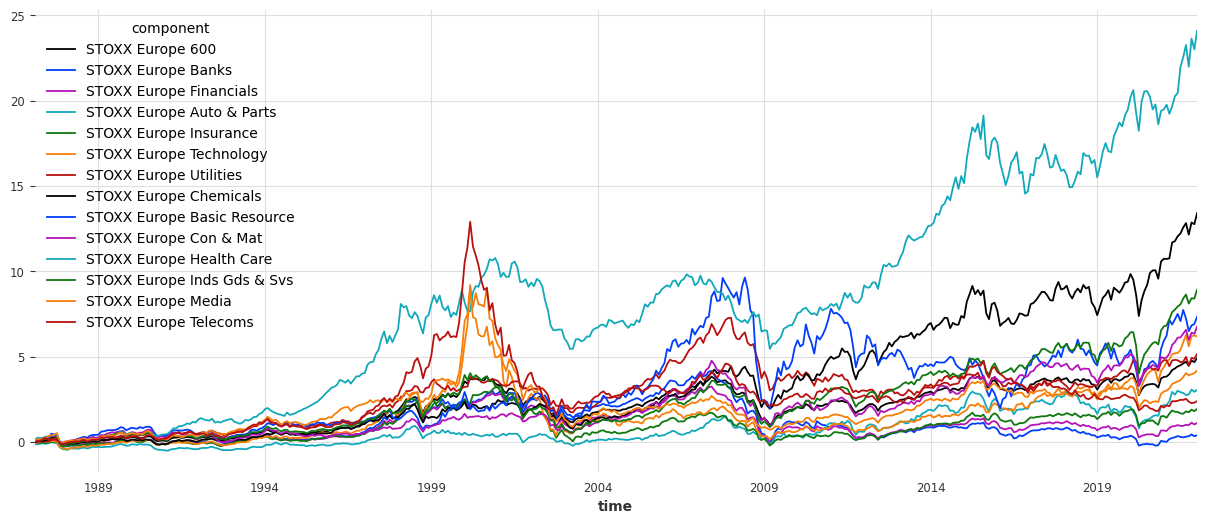

In [57]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [58]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [59]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [60]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [61]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [62]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


## Dimensionality Reduction Methods

### PLS Regression

In [63]:
hyperparameter_pls = {
    "lags": list(range(317,318,1)),
    'model': [
        sklearn.cross_decomposition.PLSRegression(n_components=n) for n in np.arange(1, 15, 1)
    ]
}

In [64]:
pls_regression_tune = RegressionModel(
    lags= hyperparameter_pls['lags'][0],
    model=sklearn.cross_decomposition.PLSRegression(n_components=0)
)

In [65]:
tuning_pls = pls_regression_tune.gridsearch(
    parameters= hyperparameter_pls,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [66]:
# print the best model parameters
best_model, best_params = tuning_pls[0], tuning_pls[1]
best_model.model_params

OrderedDict([('lags', 317),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSRegression(n_components=1)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [67]:
# pls regression model with 1 lag
pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSRegression(n_components=5))
pls_model_1.fit(train)
pls_forecast_1 = pls_model_1.predict(len(test))

# pls regression model with 316 lags
pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_316.fit(train)
pls_forecast_316 = pls_model_316.predict(len(test))

# pls regression model with 317 lags
pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_317.fit(train)
pls_forecast_317 = pls_model_317.predict(len(test))

# 335 lags was not possible to run

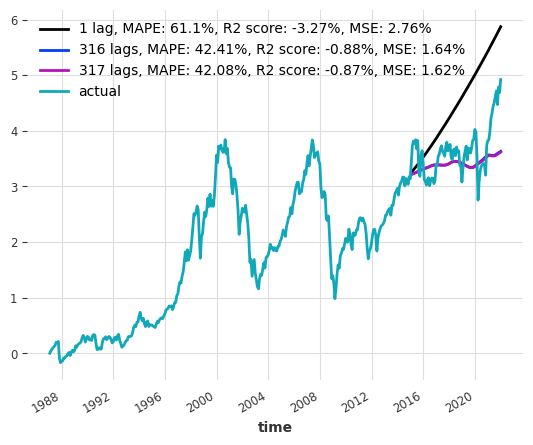

In [68]:
# plot the pls forecast with 1, 316, 317  and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_1), 2)) + '%')
pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_316), 2)) + '%')
pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [69]:
# first pls regression model with 1 lag
hf1_pls_regression = pls_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second pls regression model with 316 lags
hf2_pls_regression = pls_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third pls regression model with 317 lags
hf3_pls_regression = pls_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

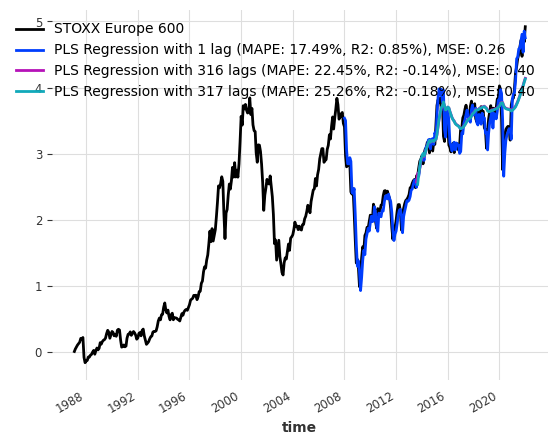

In [70]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_pls_regression, cum_returns), r2_score(hf1_pls_regression, cum_returns), mse(hf1_pls_regression, cum_returns)))
hf2_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_pls_regression, cum_returns), r2_score(hf2_pls_regression, cum_returns), mse(hf2_pls_regression, cum_returns)))
hf3_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_pls_regression, cum_returns), r2_score(hf3_pls_regression, cum_returns), mse(hf3_pls_regression, cum_returns)))

#### Portfolio

In [71]:
# change the type of the pls forecast to pandas dataframe
pls_forecast_1 = pls_forecast_1.pd_dataframe()
pls_forecast_316 = pls_forecast_316.pd_dataframe()

In [72]:
# use the pyportfolioopt library to compute the optimal portfolio 

# perform mean-variance optimization with the linear regression forecast
mu_pls_regression_1 = expected_returns.mean_historical_return(pls_forecast_1)
S_pls_regression_1 = risk_models.sample_cov(pls_forecast_1)

mu_pls_regression_316 = expected_returns.mean_historical_return(pls_forecast_316)
S_pls_regression_316 = risk_models.sample_cov(pls_forecast_316)

In [73]:
# optimize for maximal Sharpe ratio
ef_pls_regression_1 = EfficientFrontier(mu_pls_regression_1, S_pls_regression_1)
weights_pls_1 = ef_pls_regression_1.max_sharpe()

ef_pls_regression_316 = EfficientFrontier(mu_pls_regression_316, S_pls_regression_316)
weights_pls_316 = ef_pls_regression_316.max_sharpe()

In [74]:
# print the weights in a table and round them to 3 decimals and add their sum
print('Weights for PLS regression with 1 lag: ' + str(np.round(pd.Series(weights_pls_1), 3)))
print('Weights for PLS regression with 316 lags: ' + str(np.round(pd.Series(weights_pls_316), 3)))

Weights for PLS regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.949
STOXX Europe Basic Resource    0.051
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.000
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64
Weights for PLS regression with 316 lags: STOXX Europe 600              -0.0
STOXX Europe Banks            -0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         1.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals        -0.0
STOXX Europe Basic Resource   -0.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care       0.0
S

In [75]:
# compute the returns of the pls portfolio
pls_returns_1 = (cum_returns_portfolio * weights_pls_1).sum(axis=1)
pls_returns_316 = (cum_returns_portfolio * weights_pls_316).sum(axis=1)

# add portfolio returns to the dataframe
portfolio_returns['pls_regression_1'] = pls_returns_1
portfolio_returns['pls_regression_316'] = pls_returns_316

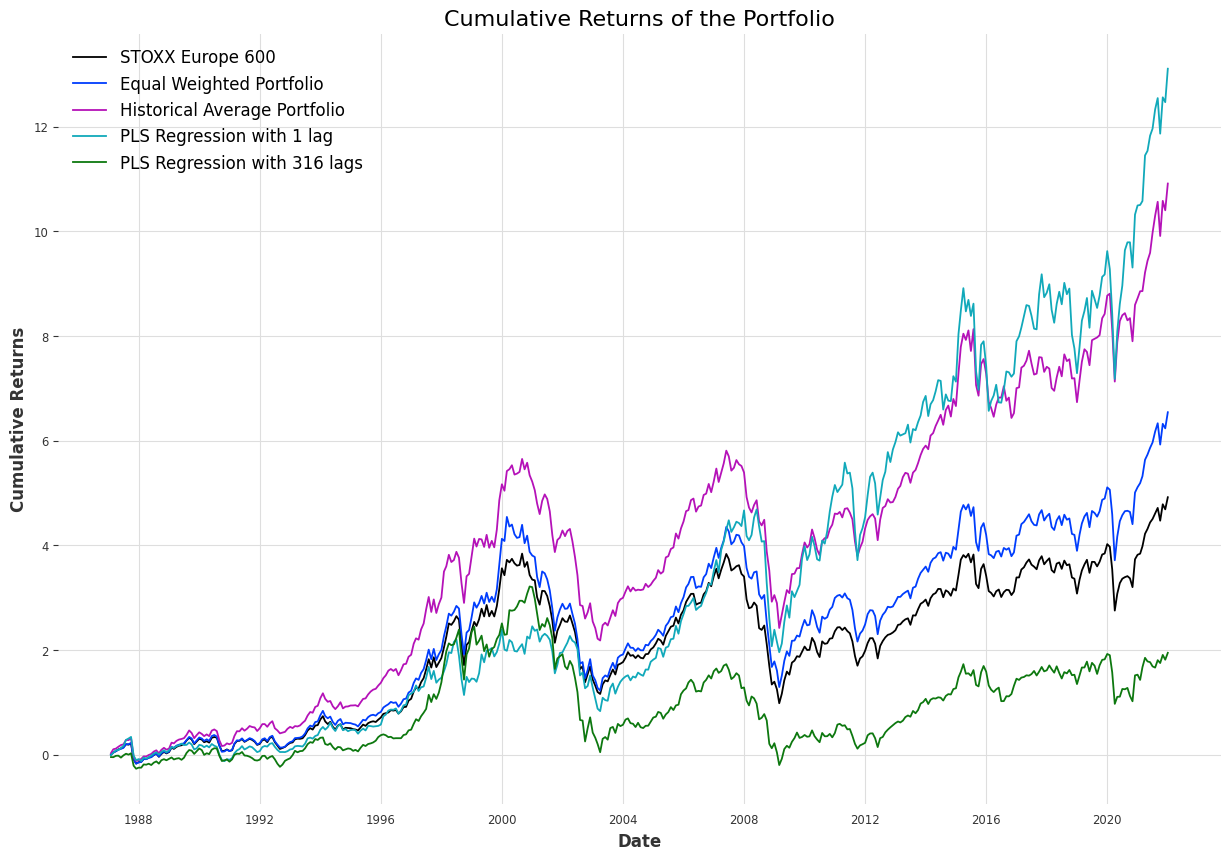

In [76]:
# plot the cumulative returns of the portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression with 1 lag')
plt.plot(portfolio_returns['pls_regression_316'], label='PLS Regression with 316 lags')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Cumulative Returns of the Portfolio', fontsize=16)
plt.show();

In [77]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 316 lags: ' + str(round(portfolio_returns['pls_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 13.11%
Last value of the pls regression portfolio with 316 lags: 1.95%


### PLS Canonical

In [78]:
hyperparameter_canonical = {
    "lags": list(range(316,317,1)),
    'model': [
        sklearn.cross_decomposition.PLSCanonical(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}

In [79]:
# pls canonical regression model
pls_canonical_tune = RegressionModel(
    lags=hyperparameter_canonical['lags'][0], 
    model= sklearn.cross_decomposition.PLSCanonical(n_components=0)
    )

In [80]:
tuning_canonical = pls_canonical_tune.gridsearch(
    parameters= hyperparameter_canonical,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [81]:
best_model, best_params = tuning_canonical[0], tuning_canonical[1]
best_model.model_params

OrderedDict([('lags', 316),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSCanonical(n_components=1)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [82]:
# canonical pls regression model with 1 lag
canonical_pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=10))
canonical_pls_model_1.fit(train)
canonical_pls_forecast_1 = canonical_pls_model_1.predict(len(test))

# canonical pls regression model with 316 lags
canonical_pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSCanonical(n_components=2))
canonical_pls_model_316.fit(train)
canonical_pls_forecast_316 = canonical_pls_model_316.predict(len(test))

# canonical pls regression model with 317 lags
canonical_pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSCanonical(n_components=14))
canonical_pls_model_317.fit(train)
canonical_pls_forecast_317 = canonical_pls_model_317.predict(len(test))

# canonical pls regression model with 335 lags
#canonical_pls_forecast_335 = RegressionModel(lags=335, model=sklearn.cross_decomposition.PLSCanonical(n_components=1))

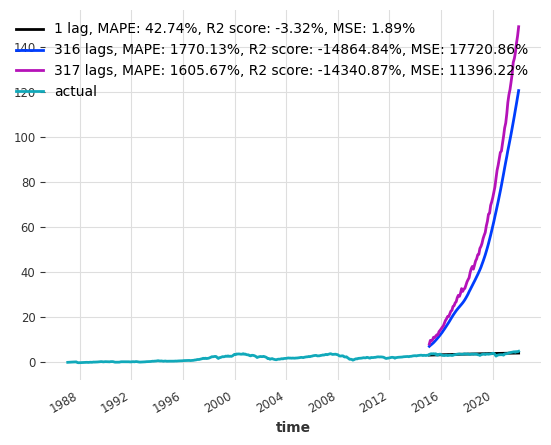

In [83]:
# plot the canonical pls forecast with 1, 316, 317 and 335 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
canonical_pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, canonical_pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_1), 2)) + '%')
canonical_pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_316), 2)) + '%')
canonical_pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_317), 2)) + '%')
#canonical_pls_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [84]:
# first canonical pls model with 1 lag
hf1_canonical_pls = canonical_pls_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second canonical pls model with 316 lags
hf2_canonical_pls = canonical_pls_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

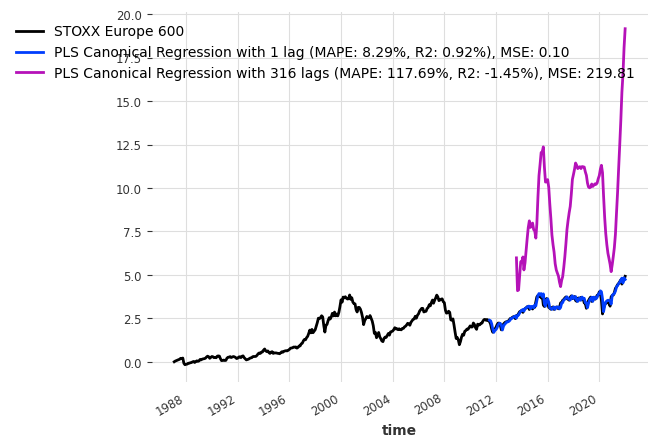

In [85]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_canonical_pls['STOXX Europe 600'].plot(label='PLS Canonical Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_canonical_pls, cum_returns), r2_score(hf1_canonical_pls, cum_returns), mse(hf1_canonical_pls, cum_returns)))
hf2_canonical_pls['STOXX Europe 600'].plot(label='PLS Canonical Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_canonical_pls, cum_returns), r2_score(hf2_canonical_pls, cum_returns), mse(hf2_canonical_pls, cum_returns)))


#### Portfolio

In [86]:
# change type of canonical pls forecast to pandas dataframe
canonical_pls_forecast_1 = canonical_pls_forecast_1.pd_dataframe()

In [87]:
# perform mean-variance optimization on the canonical pls forecast
mu_canonical_pls_1 = expected_returns.mean_historical_return(canonical_pls_forecast_1)
S_canonical_pls_1 = risk_models.sample_cov(canonical_pls_forecast_1)

In [88]:
# optimize for maximal Sharpe ratio
ef_canonical_pls_1 = EfficientFrontier(mu_canonical_pls_1, S_canonical_pls_1)
weights_canonical_pls_1 = ef_canonical_pls_1.max_sharpe()

In [89]:
# print the weights in a table and round them to 4 decimals
print('Weights for PLS Canonical regression with 1 lag: ' + str(np.round(pd.Series(weights_canonical_pls_1), 3)))


Weights for PLS Canonical regression with 1 lag: STOXX Europe 600               0.003
STOXX Europe Banks             0.003
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.250
STOXX Europe Insurance         0.005
STOXX Europe Technology        0.001
STOXX Europe Utilities         0.370
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.010
STOXX Europe Con & Mat         0.006
STOXX Europe Health Care       0.170
STOXX Europe Inds Gds & Svs    0.180
STOXX Europe Media            -0.000
STOXX Europe Telecoms         -0.000
dtype: float64


In [90]:
# compute the returns of the canonical pls portfolio
canonical_returns_1 = (cum_returns_portfolio * weights_canonical_pls_1).sum(axis=1)

# add the canonical pls portfolio to the dataframe
portfolio_returns['canonical_pls_1'] = canonical_returns_1

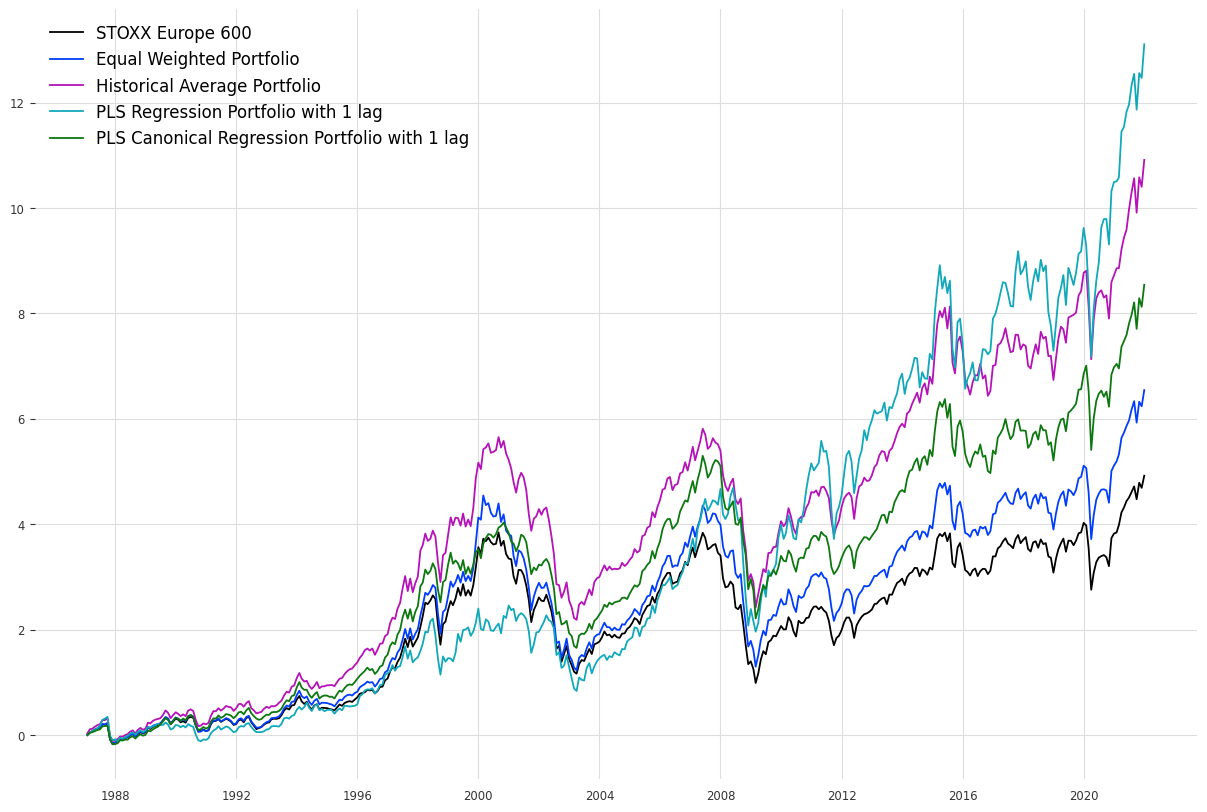

In [92]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [93]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls canonical regression portfolio with 1 lag: ' + str(round(portfolio_returns['canonical_pls_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 13.11%
Last value of the pls canonical regression portfolio with 1 lag: 8.54%


### CCA

In [94]:
hyperparameter_cca = {
    "lags": list(range(1,2, 1)),
    'model': [
        sklearn.cross_decomposition.CCA(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}

In [95]:
cca_tune = RegressionModel(
    lags= hyperparameter_cca['lags'][0],
    model=sklearn.cross_decomposition.CCA(n_components=0)
)

In [96]:
tuning_cca = cca_tune.gridsearch(
    parameters= hyperparameter_cca,
    series= train,
    val_series= test,
    start= 0.3,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/ver

In [97]:
# print the best model parameters
best_model, best_params = tuning_cca[0], tuning_cca[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', CCA()),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [164]:
# cca regression model with 1 lag
cca_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.CCA(n_components=14))
cca_model_1.fit(train)
cca_forecast_1 = cca_model_1.predict(len(test))

# cca regression model with 316 lags
cca_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_316.fit(train)
cca_forecast_316 = cca_model_316.predict(len(test))

# cca regression model with 317 lags
cca_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_317.fit(train)
cca_forecast_317 = cca_model_317.predict(len(test))

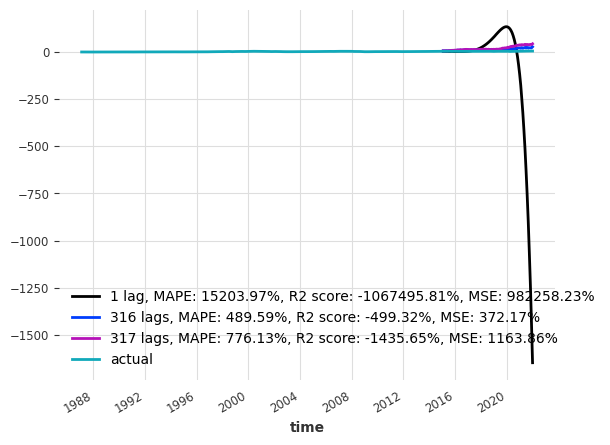

In [165]:
# plot the cca forecast with 1, 316 and 317 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
cca_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, cca_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_1), 2)) + '%')
cca_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, cca_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_316), 2)) + '%')
cca_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, cca_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [166]:
# first cca model with 1 lag
hf1_cca = cca_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second cca model with 316 lags
#hf2_cca = cca_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

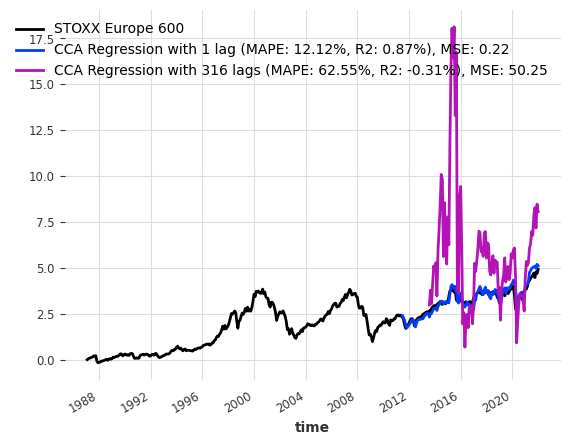

In [167]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_cca['STOXX Europe 600'].plot(label='CCA Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_cca, cum_returns), r2_score(hf1_cca, cum_returns), mse(hf1_cca, cum_returns)))
#
#hf2_cca['STOXX Europe 600'].plot(label='CCA Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_cca, cum_returns), r2_score(hf2_cca, cum_returns), mse(hf2_cca, cum_returns)))


### Portfolio

In [168]:
# change the type of the cca forecast to a dataframe
cca_forecast_1 = cca_forecast_1.pd_dataframe()

In [169]:
# perform mean-variance optimization on the cca forecast
mu_cca_1 = expected_returns.mean_historical_return(cca_forecast_1)
S_cca_1 = risk_models.sample_cov(cca_forecast_1)

In [172]:
# fill nan values with 0
mu_cca_1 = mu_cca_1.fillna(0)
S_cca_1 = S_cca_1.fillna(0)

In [173]:
# optimize for maximal Sharpe ratio
ef_cca_1 = EfficientFrontier(mu_cca_1, S_cca_1)
weights_cca_1 = ef_cca_1.max_sharpe()

In [174]:
# print the weights in a table and round them to 4 decimals
print('Weights for CCA regression with 1 lag: ' + str(np.round(pd.Series(weights_cca_1), 3)))

Weights for CCA regression with 1 lag: STOXX Europe 600               0.053
STOXX Europe Banks             0.001
STOXX Europe Financials        0.015
STOXX Europe Auto & Parts      0.025
STOXX Europe Insurance         0.008
STOXX Europe Technology        0.067
STOXX Europe Utilities         0.013
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.519
STOXX Europe Inds Gds & Svs    0.068
STOXX Europe Media             0.181
STOXX Europe Telecoms          0.050
dtype: float64


In [176]:
# compute the returns of the cca regression
cca_returns_1 = (cum_returns_portfolio * weights_cca_1).sum(axis=1)

# add the cca returns to the portfolio returns
portfolio_returns['cca_regression_1'] = cca_returns_1

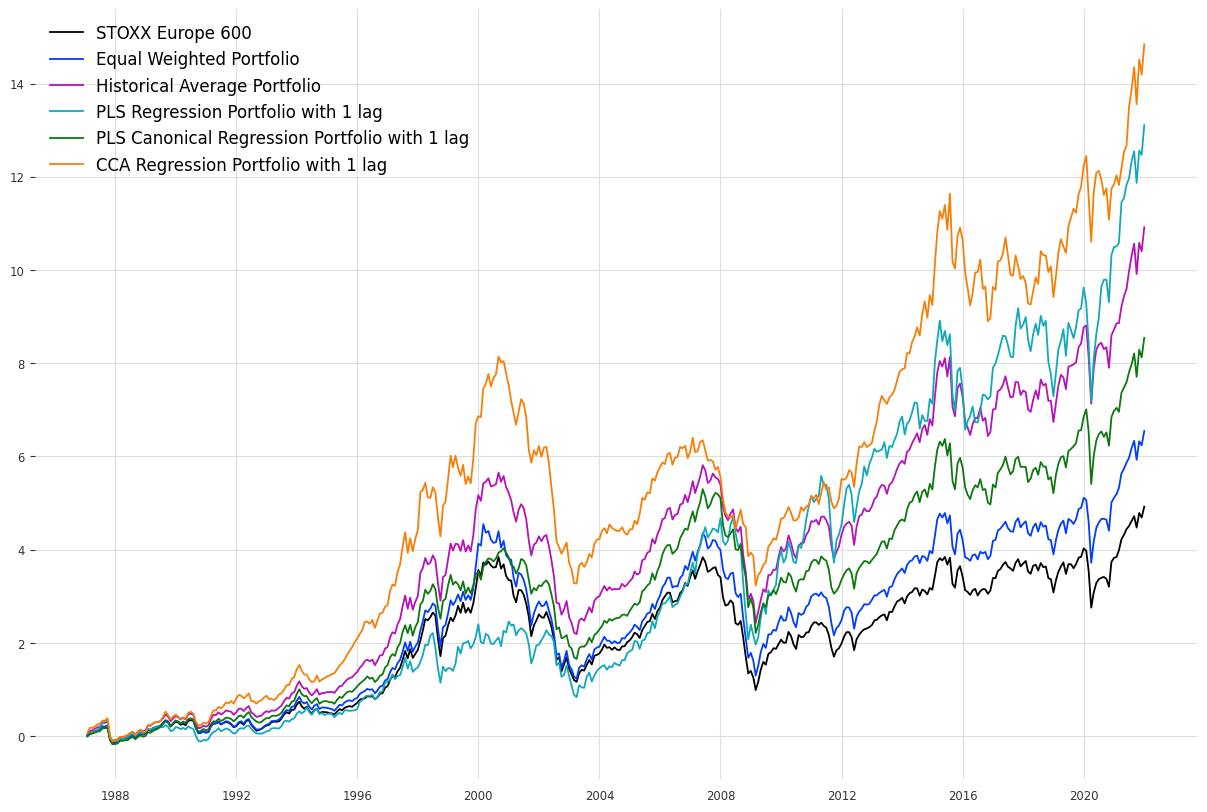

In [177]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['cca_regression_1'], label='CCA Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [178]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls canonical regression portfolio with 1 lag: ' + str(round(portfolio_returns['canonical_pls_1'].iloc[-1], 2)) + '%')
print('Last value of the cca regression portfolio with 1 lag: ' + str(round(portfolio_returns['cca_regression_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 13.11%
Last value of the pls canonical regression portfolio with 1 lag: 8.54%
Last value of the cca regression portfolio with 1 lag: 14.84%


# Outcome Shrinkage Portfolio Building

First generate a graph showing all models compared to their benchmarks & then create a table showing the numerical results.

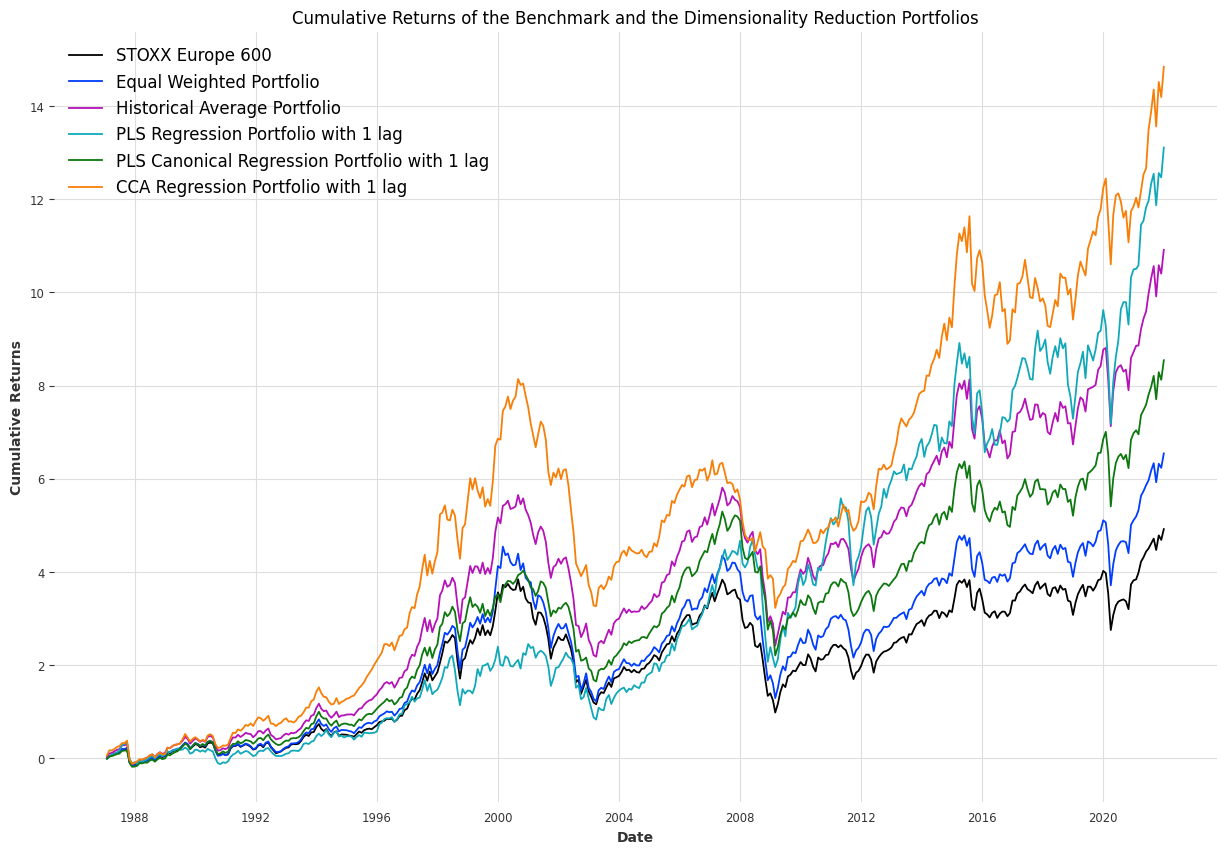

In [180]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['cca_regression_1'], label='CCA Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.title('Cumulative Returns of the Benchmark and the Dimensionality Reduction Portfolios')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
plt.show();

In [181]:
import tabulate

In [184]:
# create a dictionary with the portfolio returns
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'PLS Regression', 'PLS Canonical Regression', 'CCA Regression'],
    '1 Lag': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                portfolio_returns['equal_weighted'].tail(1).values[0],
                portfolio_returns['historical_average'].tail(1).values[0],
                portfolio_returns['pls_regression_1'].tail(1).values[0],
                portfolio_returns['canonical_pls_1'].tail(1).values[0],
                portfolio_returns['cca_regression_1'].tail(1).values[0]],
    '316 Lags': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                 portfolio_returns['equal_weighted'].tail(1).values[0],
                    portfolio_returns['historical_average'].tail(1).values[0],
                    portfolio_returns['pls_regression_316'].tail(1).values[0],
                    None,
                    None]
}

In [185]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['1 Lag', '316 Lags']] = df[['1 Lag', '316 Lags']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['1 Lag', '316 Lags'])

,1 Lag,316 Lags
Portfolio,,
STOXX Europe 600,4.921%,4.921%
Equal Weighted,6.544%,6.544%
Historical Average,10.913%,10.913%
PLS Regression,13.107%,1.948%
PLS Canonical Regression,8.543%,nan%
CCA Regression,14.842%,nan%


In [186]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"1 Lag": "{:.2%}".format, "316 Lags": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} &  1 Lag & 316 Lags \\
Portfolio                &        &          \\
\midrule
STOXX Europe 600         &  4.92\% &    4.92\% \\
Equal Weighted           &  6.54\% &    6.54\% \\
Historical Average       & 10.91\% &   10.91\% \\
PLS Regression           & 13.11\% &    1.95\% \\
PLS Canonical Regression &  8.54\% &      NaN \\
CCA Regression           & 14.84\% &      NaN \\
\bottomrule
\end{tabular}

